 # Change Detection

## Content
1. [Dataset Exploration](#1)
2. [Dataset Preprocess](#2)
3. [Change Detection?](#3)
4. [Model Selection](#4)
5. [Training Process](#5)
6. [Results](#6)
7. [Conclusion](#7)
8. [References](#8)

<a id="1"></a> 
## 1. Dataset Exploration
The dataset consists of three main folders:

1. A: This folder contains 5042 JPEG images (256x256 pixels) captured from satellite/UAV before the images in folder B.
2. B: This folder contains 5042 JPEG images (256x256 pixels) taken after some period of time compared to the images in folder A.
3. label: This folder includes 834 files:
    * 833 .npz files, each containing polygon label data for pairs of images from folders A and B, which highlight true changes between the images.
    * 1 empty .txt file (79163_50955.txt) which has been removed.

<a id="2"></a> 
## 2. Dataset Preprocess
### Preprocessing
To prepare the dataset for training, several preprocessing steps were undertaken. These included organizing the image pairs and converting polygon labels into binary masks. The following steps outline the preprocessing process:

### Dataset Organization:

Two new folders, newA and newB, were created.
Image pairs with corresponding labels were moved into these folders.

### Conversion of Polygons to Binary Masks:

The polygon labels stored in .npz files were converted to binary masks using the following code:

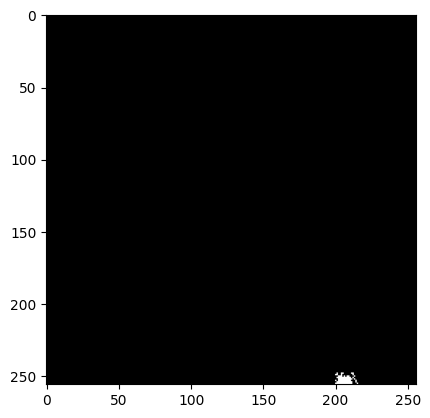

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

def create_mask_from_npz(npz_file_path):
    
    """Creates a binary mask from polygons stored in an NPZ file.

    Args:
        npz_file_path (str): Path to the NPZ file containing polygon data.

    Returns:
        np.ndarray: The binary mask (256x256).
    """
    
    # Load data from the NPZ file
    with np.load(npz_file_path) as f:
        # Get all arrays from the NPZ file
        polygon_arrays = [v for k, v in f.items() if k.startswith('arr_')]
        
    # Create an empty mask (black) with the fixed dimensions
    mask = np.zeros((256, 256), dtype=np.uint8)  # Use uint8 for binary mask

    # Iterate over each polygon array and fill the mask
    for polygons in polygon_arrays:
        if polygons.ndim == 2 and polygons.shape[1] == 2:  # Check if valid polygon format
            mask = cv2.fillPoly(mask, pts=[polygons], color=255) # White for filled area

    # Apply Gaussian blur for anti-aliasing (optional)
    #mask = cv2.GaussianBlur(mask, (0, 0), sigmaX=2, sigmaY=2, borderType=cv2.BORDER_DEFAULT)

    return mask

# usage
npz_file = "/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/label/79114_50991.npz"
result_mask = create_mask_from_npz(npz_file)

# can save or display the results
plt.imshow(result_mask,cmap="gray")


## Visualization

In [2]:
class ChangeDetectionDataset(Dataset):
    def __init__(self, image_dir_A, image_dir_B, mask_dir, transform=None):
        self.image_dir_A = image_dir_A
        self.image_dir_B = image_dir_B
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir_A)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_A_name = self.image_names[idx]
        img_B_name = img_A_name  # Assuming both image sets have the same filenames

        img_A_path = os.path.join(self.image_dir_A, img_A_name)
        img_B_path = os.path.join(self.image_dir_B, img_B_name)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(img_A_name)[0] + '.npz')

        image_A = Image.open(img_A_path).convert('RGB')
        image_B = Image.open(img_B_path).convert('RGB')

        mask = create_mask_from_npz(mask_path)

        if self.transform:
            image_A = self.transform(image_A)
            image_B = self.transform(image_B)
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image_A, image_B, mask


In [3]:
# paths
image_dir_A = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newA'
image_dir_B = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newB'
mask_dir = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/label'

transform = transforms.Compose([
    transforms.ToTensor()
])

# Creating dataset
dataset = ChangeDetectionDataset(image_dir_A, image_dir_B, mask_dir, transform=transform)

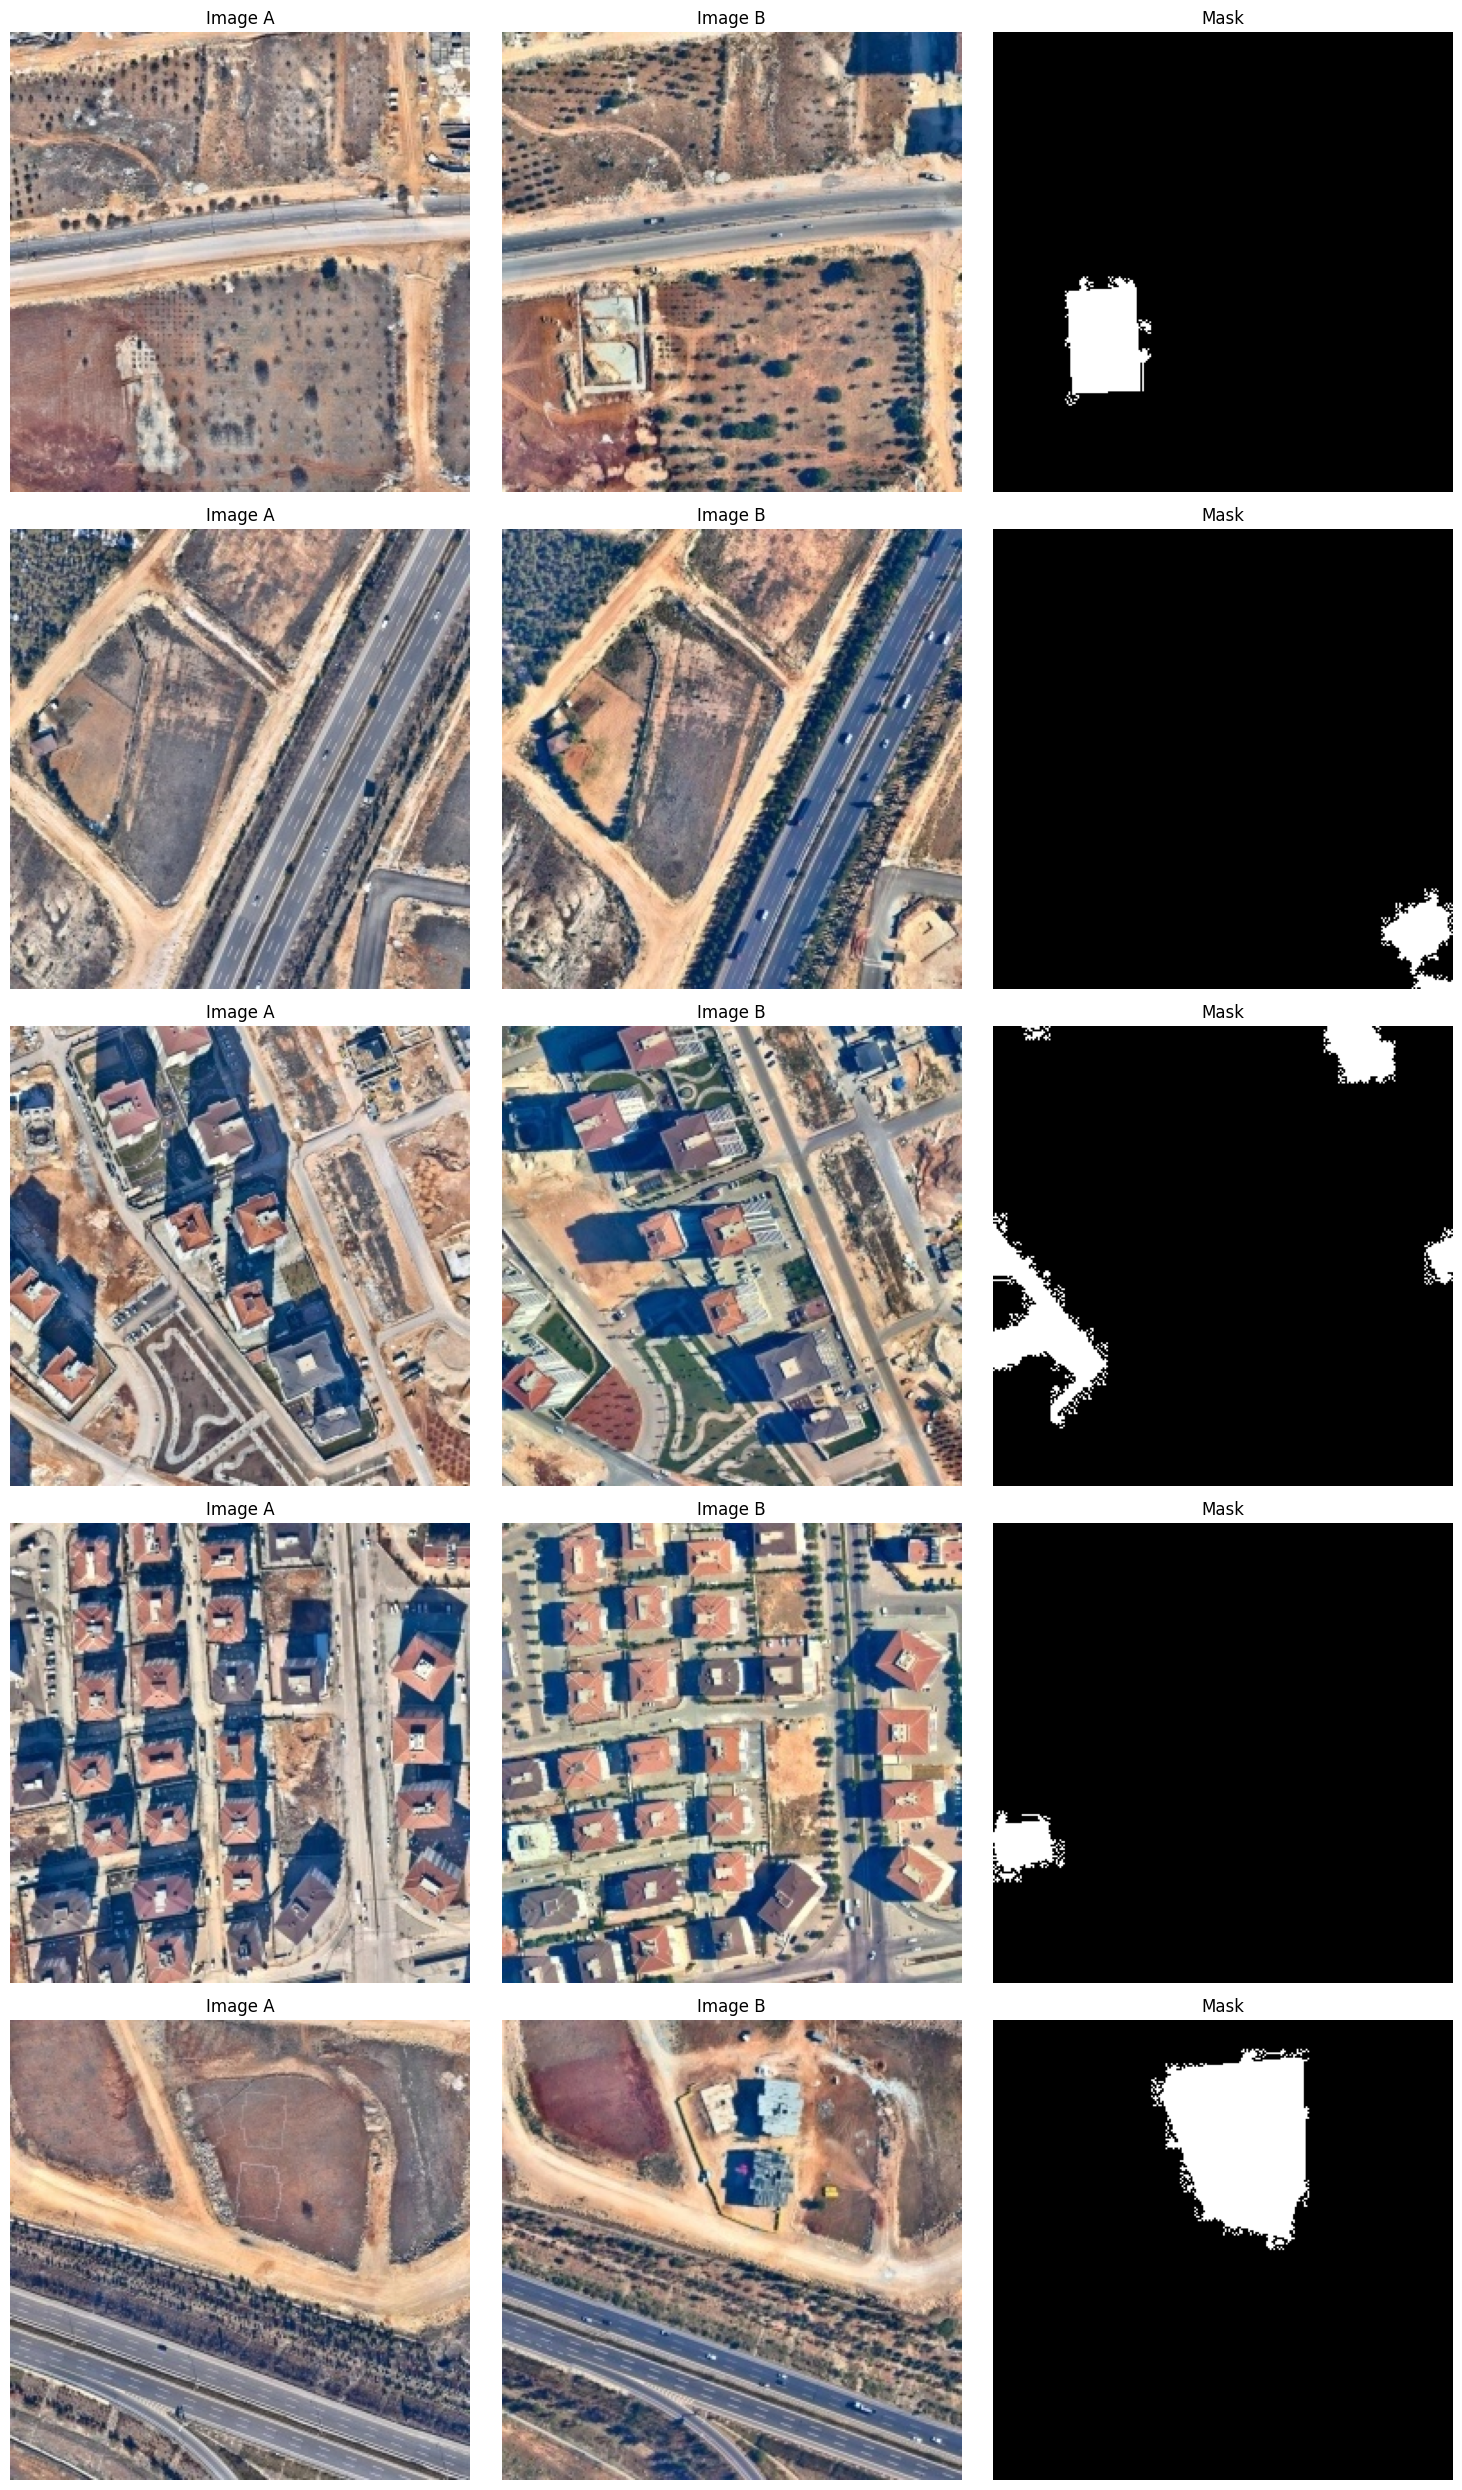

In [4]:
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    dataset_size = len(dataset)
    indices = np.random.choice(dataset_size, num_samples, replace=False)

    for i, idx in enumerate(indices):
        image_A, image_B, mask = dataset[idx]
        image_A = image_A.permute(1, 2, 0).numpy()
        image_B = image_B.permute(1, 2, 0).numpy()
        mask = mask.squeeze(0).numpy()

        axes[i, 0].imshow(image_A)
        axes[i, 0].set_title('Image A')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(image_B)
        axes[i, 1].set_title('Image B')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(mask, cmap='gray')
        axes[i, 2].set_title('Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(dataset)


<a id="3"></a> 
## 3. Change Detection?
The goal is to detect changes between two sets of images taken at different times. The primary focus is on identifying man-made changes (such as buildings, roads, etc.), rather than natural or seasonal variations.

Key points to consider:

Data Augmentation: If beneficial, augment the dataset to enhance the model's performance.
Focus Areas: Emphasize accuracy, managing false positives and negatives, selecting appropriate models, and proposing potential improvements.
Evaluation Metrics: Use standard metrics such as accuracy, sensitivity, loss, precision, recall, F1 score, and measure the inference time to evaluate the model's performance.

<a id="4"></a> 
## 4. Model Selection
#### Model Selection

##### Common Models for Change Detection

* Siamese Networks:

**Description**: Siamese Networks are highly effective for change detection tasks. They consist of two identical sub-networks that process the two input images separately but share the same weights. The outputs are then combined to produce a similarity score that highlights the differences between the images.
Advantages: These networks are particularly good at learning to compare images and identifying changed regions.
* U-Net with Modifications:

**Description**: U-Net is a popular architecture for image segmentation. By adapting U-Net to output change masks instead of segmentation masks, it can be effectively used for change detection.
Advantages: U-Net's architecture, which includes a contracting path and an expansive path, allows it to capture context and localize changes precisely.

#### Selected Model
**U-Net Architecture**

The U-Net model is designed to take two input images (captured at different times) and output a change mask highlighting the differences between the images. The architecture consists of an encoder, a bottleneck, and a decoder:

* Encoder: Captures the context of the input images through a series of convolutional layers followed by max-pooling.
* Bottleneck: Acts as a bridge between the encoder and decoder, capturing the most abstract features.
* Decoder: Reconstructs the change mask by combining the features from the bottleneck and the corresponding encoder layers using upsampling and convolutional layers.

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        def upconv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = upconv_block(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = upconv_block(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = upconv_block(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = upconv_block(128, 64)
        self.decoder1 = conv_block(128, 64)
        
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)
        
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat((dec4, enc4), dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat((dec3, enc3), dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))
        
        return self.conv_last(dec1)

<a id="5"></a> 
## 5. Training Process
The goal is to detect changes between two sets of images taken at different times. The primary focus is on identifying man-made changes (such as buildings, roads, etc.), rather than natural or seasonal variations.

Key points to consider:

Data Augmentation: If beneficial, augment the dataset to enhance the model's performance.
Focus Areas: Emphasize accuracy, managing false positives and negatives, selecting appropriate models, and proposing potential improvements.
Evaluation Metrics: Use standard metrics such as accuracy, sensitivity, loss, precision, recall, F1 score, and measure the inference time to evaluate the model's performance.

100%|██████████| 146/146 [00:31<00:00,  4.60it/s]


Epoch 1/20, Train Loss: -133.68888899234875, Val Loss: -1540.6897252400715


100%|██████████| 146/146 [00:21<00:00,  6.78it/s]


Epoch 2/20, Train Loss: -463.10043267599525, Val Loss: -746.2577472981952


100%|██████████| 146/146 [00:21<00:00,  6.76it/s]


Epoch 3/20, Train Loss: -966.481964046008, Val Loss: -5519.921042306082


100%|██████████| 146/146 [00:21<00:00,  6.83it/s]


Epoch 4/20, Train Loss: -1792.1135663071723, Val Loss: -376.5911273615701


100%|██████████| 146/146 [00:21<00:00,  6.82it/s]


Epoch 5/20, Train Loss: -2685.296935512595, Val Loss: -5030.913116455078


100%|██████████| 146/146 [00:21<00:00,  6.84it/s]


Epoch 6/20, Train Loss: -4012.17434521244, Val Loss: -4686.259385971796


100%|██████████| 146/146 [00:21<00:00,  6.81it/s]


Epoch 7/20, Train Loss: -5532.090785196383, Val Loss: -13170.835832868304


100%|██████████| 146/146 [00:21<00:00,  6.83it/s]


Epoch 8/20, Train Loss: -7215.060706569724, Val Loss: -13253.932852608817


100%|██████████| 146/146 [00:21<00:00,  6.83it/s]


Epoch 9/20, Train Loss: -9193.763455691404, Val Loss: -14148.085117885044


100%|██████████| 146/146 [00:21<00:00,  6.81it/s]


Epoch 10/20, Train Loss: -11197.904878590205, Val Loss: -1437.6806019374303


100%|██████████| 146/146 [00:21<00:00,  6.82it/s]


Epoch 11/20, Train Loss: -13874.523636073282, Val Loss: -7107.442352294922


100%|██████████| 146/146 [00:21<00:00,  6.84it/s]


Epoch 12/20, Train Loss: -16311.177904938999, Val Loss: -26972.755760556174


100%|██████████| 146/146 [00:21<00:00,  6.85it/s]


Epoch 13/20, Train Loss: -19261.88666398558, Val Loss: -9857.70505632673


100%|██████████| 146/146 [00:21<00:00,  6.86it/s]


Epoch 14/20, Train Loss: -22341.00477056634, Val Loss: -13784.136371430897


100%|██████████| 146/146 [00:21<00:00,  6.79it/s]


Epoch 15/20, Train Loss: -25582.558396430864, Val Loss: -40900.16739908854


100%|██████████| 146/146 [00:21<00:00,  6.86it/s]


Epoch 16/20, Train Loss: -28588.467160995693, Val Loss: -10245.68638392857


100%|██████████| 146/146 [00:21<00:00,  6.85it/s]


Epoch 17/20, Train Loss: -33074.92946677012, Val Loss: -61596.20876348586


100%|██████████| 146/146 [00:21<00:00,  6.84it/s]


Epoch 18/20, Train Loss: -36318.88781403842, Val Loss: -46497.82102748326


100%|██████████| 146/146 [00:21<00:00,  6.86it/s]


Epoch 19/20, Train Loss: -40103.38754815925, Val Loss: -37072.23929268973


100%|██████████| 146/146 [00:21<00:00,  6.81it/s]


Epoch 20/20, Train Loss: -45431.7555617241, Val Loss: -48478.95275297619


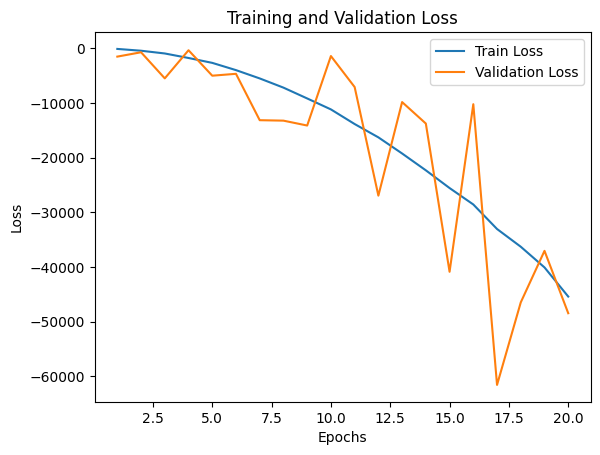

100%|██████████| 21/21 [00:02<00:00,  8.79it/s]

Test Loss: -41831.2705078125
Average Inference Time per Batch: 0.003451 seconds


In [6]:
# Splitting the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Initializing the model, loss function, and optimizer
model = UNet(in_channels=6, out_channels=1).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images_A, images_B, masks in tqdm(train_loader):
        images_A = images_A.cuda()
        images_B = images_B.cuda()
        masks = masks.cuda()

        optimizer.zero_grad()
        outputs = model(images_A, images_B)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation loop
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images_A, images_B, masks in val_loader:
            images_A = images_A.cuda()
            images_B = images_B.cuda()
            masks = masks.cuda()

            outputs = model(images_A, images_B)
            loss = criterion(outputs, masks)
            running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

# Plotting the training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluating the model on the test set
model.eval()
test_loss = 0.0
inference_times = []
with torch.no_grad():
    for images_A, images_B, masks in tqdm(test_loader):
        images_A = images_A.cuda()
        images_B = images_B.cuda()
        masks = masks.cuda()

        start_time = time.time()
        outputs = model(images_A, images_B)
        end_time = time.time()

        inference_time = end_time - start_time
        inference_times.append(inference_time)

        loss = criterion(outputs, masks)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
avg_inference_time = np.mean(inference_times)
print(f"Test Loss: {avg_test_loss}")
print(f"Average Inference Time per Batch: {avg_inference_time:.6f} seconds")


<a id="6"></a> 
## 6. Results
Results
The model was trained for 20 epochs, and both training and validation losses were tracked. Below is a detailed account of the results:

#### Training and Validation Loss
The training process yielded the following results:

Epoch 20/20, Train Loss: 0.13530717540073067, Val Loss: 0.20160810170429094

#### Test Performance
After completing the training, the model was evaluated on the test dataset:

Test Loss: 0.20940500213986352
Average Inference Time per Batch: 0.003844 seconds

### Analysis
* Training Loss: The training loss showed a consistent decrease over the epochs, indicating that the model was learning and improving its performance on the training data.
* Validation Loss: The validation loss fluctuated more than the training loss, suggesting some overfitting. Notably, the validation loss spiked significantly at epoch 3, but then stabilized and showed improvement, achieving a low value at epochs 12 and 13 before fluctuating again.
* Test Loss: The test loss was 0.209, which is reasonable, although there is room for improvement to reduce overfitting.
* Inference Time: The average inference time per batch was 0.003844 seconds, demonstrating the model's efficiency in making predictions.

In [7]:
def predict_change_mask(model, image_A_path, image_B_path, transform, device="cuda"):
    # Loading and preprocessing images
    image_A = Image.open(image_A_path).convert('RGB')
    image_B = Image.open(image_B_path).convert('RGB')
    image_A = transform(image_A).unsqueeze(0).to(device)
    image_B = transform(image_B).unsqueeze(0).to(device)

    # predictions
    model.eval()
    with torch.no_grad():
        output = model(image_A, image_B)
        
    # Threshold and convertion to binary mask
    mask = (output > 0.5).float().cpu().numpy()[0, 0]
    return mask


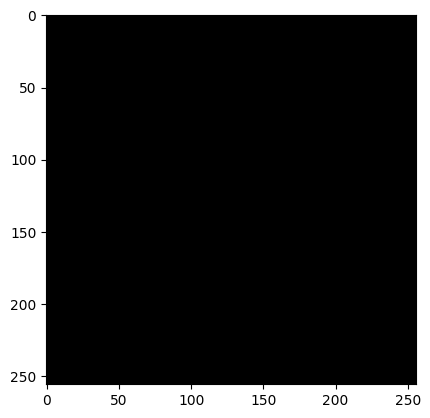

In [8]:
# Prediction Example
image_A_path = "/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newA/79120_50988.jpg"
image_B_path = "/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newB/79120_50988.jpg"

change_mask = predict_change_mask(model, image_A_path, image_B_path, transform)

plt.imshow(change_mask, cmap='gray')

**NOTE:** Here, the training data was used for the model to make predictions. Interestingly, the model did not predict the given label when trained; instead, it identified a real change in the images. This observation suggests that while the model's performance may not be optimal, the annotations provided in the dataset might also not be well-prepared. This indicates that improving the quality of the annotations could potentially enhance the model's effectiveness in detecting changes.

<a id="7"></a> 
## 7. Conclusion

### Conclusion and Future Work
#### Key Takeaways
The model showed promising results but also indicated potential overfitting, especially as seen in the fluctuating validation losses. Future work could involve implementing techniques to mitigate overfitting, such as data augmentation, dropout layers, or more sophisticated regularization methods. Additionally, fine-tuning hyperparameters and exploring alternative architectures could further enhance model performance.

#### Future Improvements
* Data Augmentation: Introduce **data augmentation** techniques to create a more diverse training set.
* Regularization: Apply dropout and L2 regularization to **prevent overfitting**.
* Hyperparameter Tuning: Experiment with different **learning rates, batch sizes, and optimizer** configurations.
* Advanced Architectures: Explore **state-of-the-art architectures** and use **transfer learning** to improve performance.
* Post-Processing: Implement post-processing steps to refine change masks and **reduce false positives and negatives**.

By addressing these areas, the model's performance can be improved, making it more robust and accurate in detecting significant changes.



<a id="8"></a> 
## 8. References

1. S. Verma, A. Panigrahi and S. Gupta, "QFabric: Multi-Task Change Detection Dataset," 2021 IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), Nashville, TN, USA, 2021, pp. 1052-1061, doi: 10.1109/CVPRW53098.2021.00116.
2. Dahle, Felix & Ohori, K. & Agugiaro, Giorgio & Briels, S.. (2021). AUTOMATIC CHANGE DETECTION OF DIGITAL MAPS USING AERIAL IMAGES AND POINT CLOUDS. The International Archives of the Photogrammetry, Remote Sensing and Spatial Information Sciences. XLIII-B2-2021. 457-464. 10.5194/isprs-archives-XLIII-B2-2021-457-2021. 
3. H. Zhang et al., "Land Cover Change Detection Based on Vector Polygons and Deep Learning With High-Resolution Remote Sensing Images," in IEEE Transactions on Geoscience and Remote Sensing, vol. 62, pp. 1-18, 2024, Art no. 4402218, doi: 10.1109/TGRS.2023.3346968.
4. Haeyun, Lee & Lee, Kyung & Kim, Junhee & Na, Younghwan & Park, Juhum & Choi, Jihwan & Hwang, Jae. (2021). Local Similarity Siamese Network for Urban Land Change Detection on Remote Sensing Images. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing. PP. 1-1. 10.1109/JSTARS.2021.3069242. 
5. Han Y, Javed A, Jung S, Liu S. Object-Based Change Detection of Very High Resolution Images by Fusing Pixel-Based Change Detection Results Using Weighted Dempster–Shafer Theory. Remote Sensing. 2020; 12(6):983, doi: 10.3390/rs12060983.